## Compares the trends between high and low z cuts.
Uses the halorun catalog which is the final version used in the paper, it compares the global richness-mass trends between high z and low z clusters. 

In [61]:
import numpy as np
import sys
import pickle
sys.path.append('/home/zzbenjamin94/Desktop/Astronomy/Research/DES_Galaxy_Cluster')

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from tools.plot_utils import plot_pretty
plot_pretty()
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from tools.setup.setup import tools_home_dir, home_dir, bigdata_home_dir
import astropy.io.fits as fits
shapedir = home_dir()+'output/buzzard/halo_shape/'
#tpltdir = home_dir() + 'output/lmda_cosi_chains/hrun/'
tpltdir = home_dir() + 'output/lmda_cosi_chains/redM_Buzzard/v1.3/'
buzzdir = home_dir() + 'output/buzzard/'
bigdatadir = bigdata_home_dir()
toolsdir = tools_home_dir()
homedir = home_dir()

import astropy.io.fits as pyfits
import ConfigParser
import healpy as hp
import treecorr
import os

from repo.halo_shape.halo_shape_stats_backend import kmeans_stats, student_t_test
from repo.halo_shape.read_shape_param import halo_bin_stat, read_shape_param
from lmda_cosi_model import *

In [62]:
#from repo.richness_mass.lmda_cosi_model import make_model, make_model2, make_model3 #this takes a while because of tab hmf
from pymc import *
from pymc import DiscreteUniform, Normal, uniform_like, TruncatedNormal
from pymc import Metropolis
from numpy.random import randn
import matplotlib.pyplot as plt
from scipy.special import erf
from chainconsumer import ChainConsumer

## RedM fullrun Catalog

In [91]:
from repo.halo_shape.read_shape_param import read_shape_param
import numpy.lib.recfunctions as rfn
import pickle

##TODO: Read fullrun .data file. 

filename = buzzdir +'redM_halos_fullmatchingparams_matchingv1.3_Buzzardv1.6.data'
infile = open(filename,'rb')
redM_data = pickle.load(infile)
infile.close()

print "Number of halos in the full catalog is ", len(redM_data)
print redM_data.dtype

#Apply mass cut
masscut = np.where(redM_data.M200B > 1e13)
redM_data = redM_data[masscut]
print "After mass cut number of halos is ", len(redM_data)

Number of halos in the full catalog is  13628
(numpy.record, [('GALAXY_ID', '<i8'), ('HALOID', '<i8'), ('DESCID', '>i8'), ('RA_OBS', '>f8'), ('DEC_OBS', '>f8'), ('TRA', '>f8'), ('TDEC', '>f8'), ('Z', '>f8'), ('MVIR', '>f8'), ('VMAX', '>f8'), ('VRMS', '>f8'), ('RVIR', '>f8'), ('RS', '>f8'), ('NP', '>f8'), ('PX', '>f8'), ('PY', '>f8'), ('PZ', '>f8'), ('VX', '>f8'), ('VY', '>f8'), ('VZ', '>f8'), ('JX', '>f8'), ('JY', '>f8'), ('JZ', '>f8'), ('SPIN', '>f8'), ('RS_KLYPIN', '>f8'), ('MVIR_ALL', '>f8'), ('M200B', '>f8'), ('M200C', '>f8'), ('M500C', '>f8'), ('M2500C', '>f8'), ('XOFF', '>f8'), ('VOFF', '>f8'), ('SPIN_BULLOCK', '>f8'), ('B_TO_A', '>f8'), ('C_TO_A', '>f8'), ('PID', '>i8'), ('LUMTOT', '>f8'), ('LUM20', '>f8'), ('LBCG', '>f8'), ('NGALS', '>i8'), ('N18', '>i8'), ('N19', '>i8'), ('N20', '>i8'), ('N21', '>i8'), ('N22', '>i8'), ('matching_ID', '<i8'), ('MEM_MATCH_ID', '<i8'), ('LAMBDA_CHISQ', '<f8'), ('RA_REDM', '<f8'), ('DEC_REDM', '<f8'), ('q', '<f8'), ('s', '<f8'), ('cosi', '<f8'), (

In [92]:
##Shorthand name for relevant halo/redM parameters
richness = redM_data.LAMBDA_CHISQ
halos_M  = redM_data.M200B
halos_ID = redM_data.HALOID
q = redM_data.q
s = redM_data.s
cos_i = redM_data.cosi

print "Halo mass range is from ", min(np.log10(halos_M)), max(np.log10(halos_M))

Halo mass range is from  13.000564216165376 15.53186194909581


In [102]:
##cosi cut 
cut = 0.5

high_cut = np.where((redM_data['cosi'] >= 0.8))
redM_data_highcosi = redM_data[high_cut]

low_cut = np.where((redM_data['cosi'] < 0.2))
redM_data_lowcosi = redM_data[low_cut]

print "Low cosi: ", len(redM_data_lowcosi)
print "High cosi: ", len(redM_data_highcosi)

Low cosi:  2086
High cosi:  3798


In [103]:
##Redshiftcut. 
cut = 0.5

high_cut = np.where((redM_data['Z'] >= cut))
redM_data_highz = redM_data[high_cut]

low_cut = np.where((redM_data['Z'] < cut))
redM_data_lowz = redM_data[low_cut]

print "Low-z: ", len(redM_data_lowz)
print "High-z: ", len(redM_data_highz)

Low-z:  5979
High-z:  7649


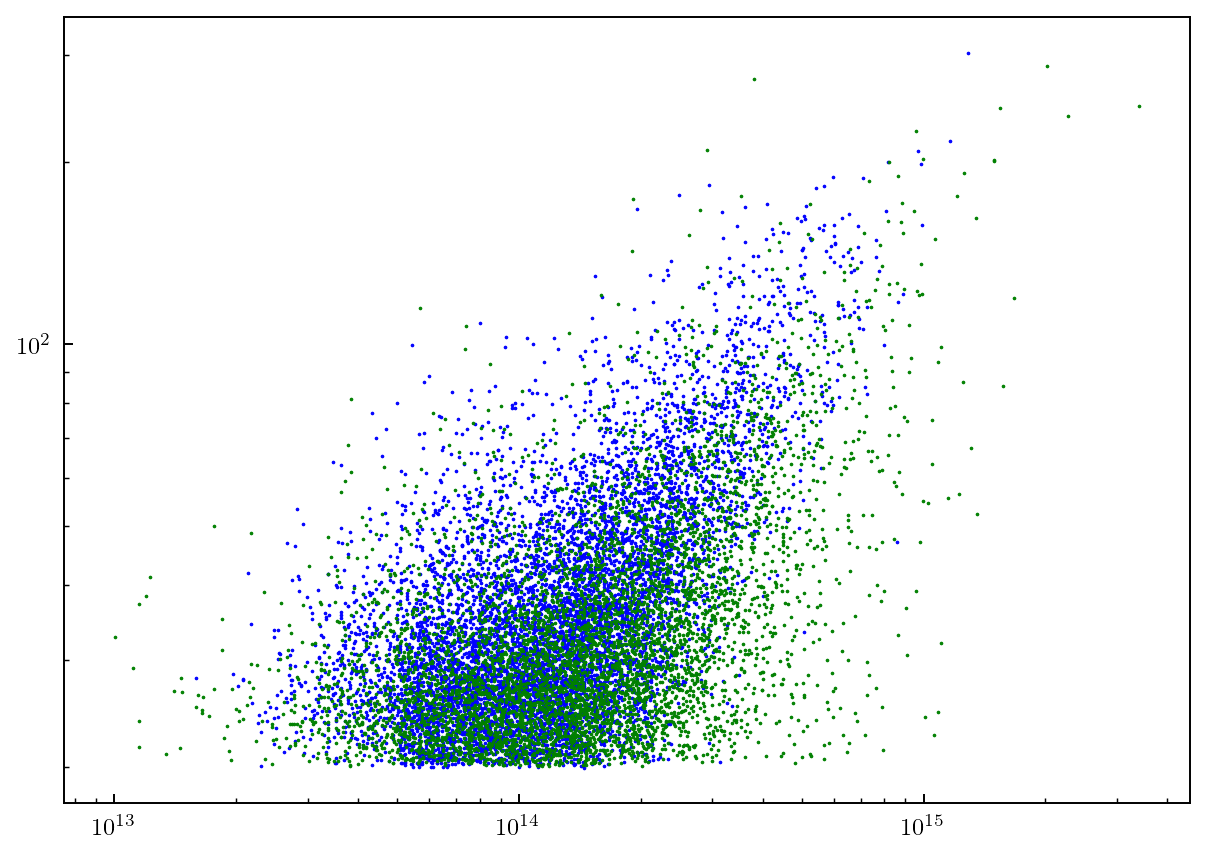

In [104]:
fig, axs = plt.subplots(1 ,1, tight_layout=True, figsize=(7,5))
axs.plot(redM_data_highz.M200B, redM_data_highz.LAMBDA_CHISQ, 'k.',c='blue', markersize=1)
axs.plot(redM_data_lowz.M200B, redM_data_lowz.LAMBDA_CHISQ, 'k.',c='green', markersize=1)
plt.xscale('log'); plt.yscale('log')

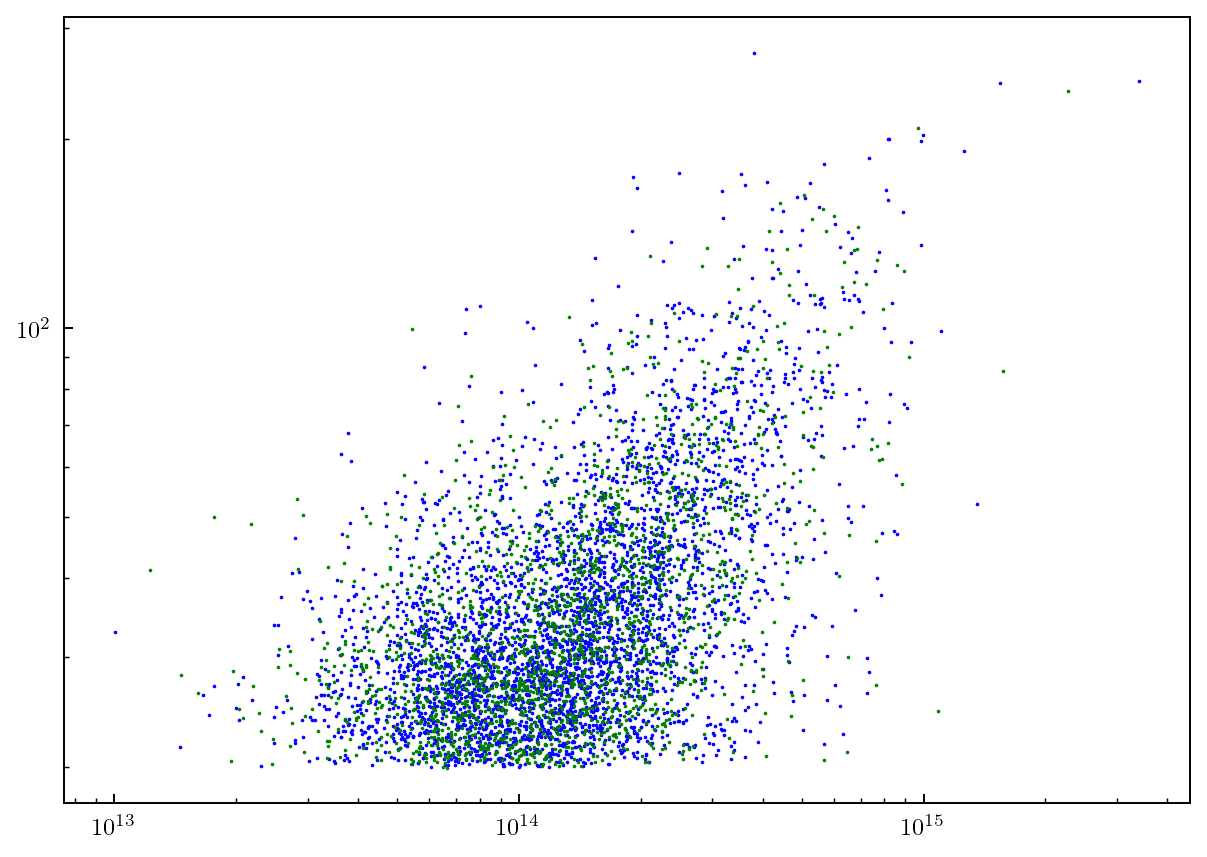

In [105]:
fig, axs = plt.subplots(1 ,1, tight_layout=True, figsize=(7,5))
axs.plot(redM_data_highcosi.M200B, redM_data_highcosi.LAMBDA_CHISQ, 'k.',c='blue', markersize=1)
axs.plot(redM_data_lowcosi.M200B, redM_data_lowcosi.LAMBDA_CHISQ, 'k.',c='green', markersize=1)
plt.xscale('log'); plt.yscale('log')

## Halo run catalog

In [63]:
from repo.halo_shape.read_shape_param import read_shape_param
import numpy.lib.recfunctions as rfn

filename = 'halo_shape_hruncut_allz.npy'
halo_shape = np.load(shapedir+filename)
num_bcut = len(halo_shape)

#Apply convergence cut
conv_cut = np.where(halo_shape['converge']==True)
halo_shape = halo_shape[conv_cut]
print "After convergence cut ", len(halo_shape), " out of initial ", num_bcut, " remain." 

#Find corresponding richness and mass of halos_ID in hrun, after shape cut
filename = bigdatadir + 'Buzzard_Sims/v1.6/halo_run/'+'buzzard-0_1.6_y3_run_halos_lambda_chisq_chto_fullhalo_final_chto.fit'
hrun_list = fits.open(filename)
hrun_data = hrun_list[1].data


After convergence cut  133637  out of initial  134908  remain.


In [64]:
#First do a lambda cut
lmda_cut = np.where((hrun_data['LAMBDA_CHISQ'] >= 20))
hrun_data = hrun_data[lmda_cut]
print "lmda for hrun completed: ", len(hrun_data), " halos remain"

shapecut = [ind for (ind, val) in enumerate(hrun_data['HALOID']) if val in halo_shape['halos_ID']]
hrun_data = hrun_data[shapecut]
print "shapecut for hrun completed: ", len(hrun_data), " halos remain"

ID_cut = [ind for (ind, val) in enumerate(halo_shape['halos_ID']) if val in hrun_data['HALOID']] 
halo_shape = halo_shape[ID_cut] 
print "ID_cut for halo_shape completed: ", len(halo_shape), " halos remain"

assert len(halo_shape) == len(hrun_data), 'hrun_data and halo_shape don\'t have equal number of halos'

lmda for hrun completed:  60955  halos remain
shapecut for hrun completed:  53305  halos remain
ID_cut for halo_shape completed:  53305  halos remain


In [75]:
##Redshift and halo shape cut. 
zcut = 0.65

highz_cut = np.where((hrun_data['Z'] >= zcut))
hrun_data_highz = hrun_data[highz_cut]

lowz_cut = np.where((hrun_data['Z'] < zcut))
hrun_data_lowz = hrun_data[lowz_cut]

print "Low-z: ", len(hrun_data_lowz)
print "High-z: ", len(hrun_data_highz)

Low-z:  23904
High-z:  29401


### Plotting the binned richness-mass


In [87]:
##Shorthand name for relevant halo/redM parameters
richness= hrun_data.LAMBDA_CHISQ
halos_M = hrun_data.M200B
halos_ID_shapecut, q, s, cos_i =  read_shape_param(halo_shape, convcut=True)


In [99]:
cosi_cut = 0.5

high_cut = np.where((cos_i >= 0.8))
low_cut = np.where((cos_i < 0.2))

richness_high = richness[high_cut]
richness_low = richness[low_cut]
halos_M_high = halos_M[high_cut]
halos_M_low = halos_M[low_cut]

print "Low-z: ", len(richness_low)
print "High-z: ", len(richness_high)

Low-z:  2086
High-z:  3798


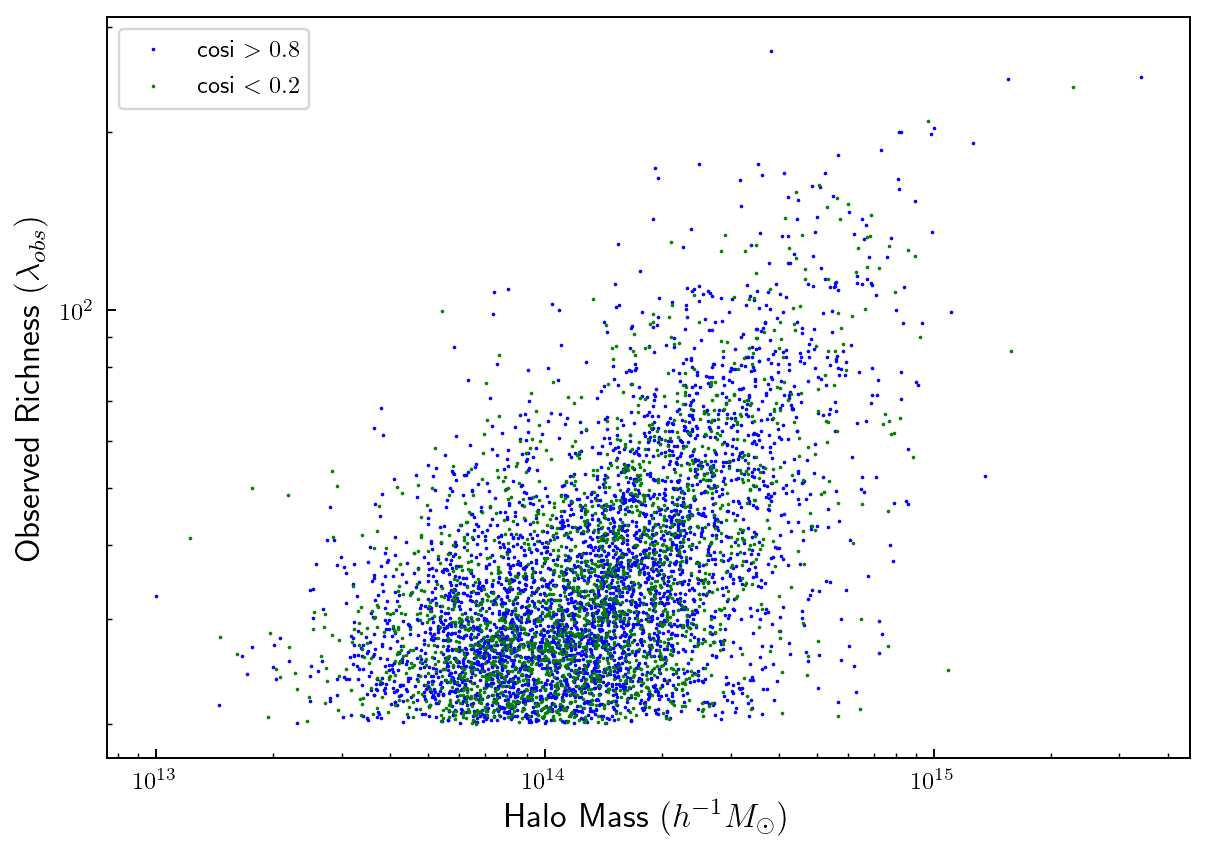

In [101]:
fig, axs = plt.subplots(1 ,1, tight_layout=True, figsize=(7,5))
axs.plot(halos_M_high, richness_high, 'k.',c='blue', markersize=1, label=r'cosi $>0.8$')
axs.plot(halos_M_low, richness_low, 'k.',c='green', markersize=1, label='cosi  $<0.2$')
plt.xscale('log'); plt.yscale('log')
axs.set_xlabel('Halo Mass $(h^{-1}M_\odot)$',fontsize=14)
axs.set_ylabel('Observed Richness $(\lambda_{obs})$',fontsize=14)
plt.legend()
plt.show()

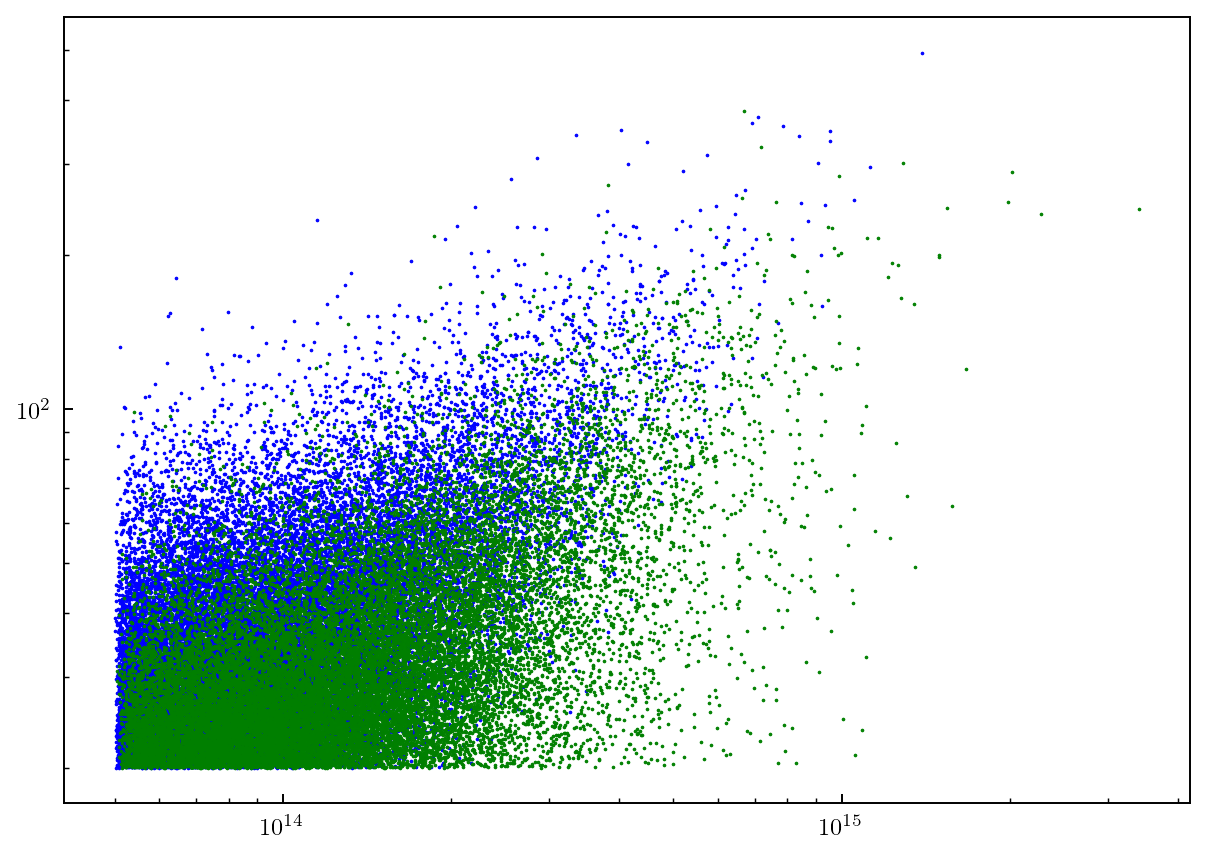

In [76]:
fig, axs = plt.subplots(1 ,1, tight_layout=True, figsize=(7,5))
axs.plot(hrun_data_highz.M200B, hrun_data_highz.LAMBDA_CHISQ, 'k.',c='blue', markersize=1)
axs.plot(hrun_data_lowz.M200B, hrun_data_lowz.LAMBDA_CHISQ, 'k.',c='green', markersize=1)
plt.xscale('log'); plt.yscale('log')

# High Z

In [19]:
##Shorthand name for relevant halo/redM parameters
richness= hrun_data_highz.LAMBDA_CHISQ
halos_M = hrun_data_highz.M200B
halos_ID_shapecut, q, s, cos_i =  read_shape_param(halo_shape_highz, convcut=True)

### Binning Halos Files -- by cos(i) and richness, creating redshift cut

In [20]:
from repo.halo_shape.read_shape_param import halo_bin_stat

#Bin by cosine
cosi_num_bin = 5
cosi_bin_edge = np.linspace(0,1,cosi_num_bin+1)
cosi_bins = []
for i in range(cosi_num_bin):
    cosi_bins.append([cosi_bin_edge[i], cosi_bin_edge[i+1]])
    
cosi_bins_ind = halo_bin_stat(cos_i, cosi_bins)
    
#Bin by richness
lmda_max = np.max(richness)
lmda_bins = [[20,30],[30,50],[50,lmda_max]] #upper limit must match lower limit of next bin
num_lmda_bins = len(lmda_bins)
lmda_bins_ind = halo_bin_stat(richness, lmda_bins)
print 'Maximum richness after cuts is ', lmda_max

#Contains all halos. List should be of length with an array that contains all halos.
all_ind = [np.arange(len(q))]

Maximum richness after cuts is  494.7688


In [21]:
#Binning richness by cos_i
num_bins = len(cosi_bins)
lnM200b_binned = [None]*num_bins
lnl_binned = [None]*num_bins

lnl = np.log(richness)
lnM200b = np.log(halos_M)

for i, cosi_bin in enumerate(cosi_bins):
    lnM200b_binned[i] = np.log(halos_M[cosi_bins_ind[i]])
    lnl_binned[i] = np.log(richness[cosi_bins_ind[i]])

## MCMC Posterior

In [23]:
#MCMC chain setup
num=200
n_iter=num*6000
n_burn=num*500
n_thin=num    

mcmc_folder = tpltdir  + 'high_z/' 'p_lmda_cosi_'+'all'+'_model1'
M=pymc.Model(make_model(lnl, lnM200b))
mc=MCMC(M, db='txt', dbname=mcmc_folder)
mc.sample(iter=n_iter, burn=n_burn, thin=n_thin)

 [-----------------100%-----------------] 1200000 of 1200000 complete in 7712.5 sec

# Low Z

In [24]:
##Shorthand name for relevant halo/redM parameters
richness= hrun_data_lowz.LAMBDA_CHISQ
halos_M = hrun_data_lowz.M200B
halos_ID_shapecut, q, s, cos_i =  read_shape_param(halo_shape_lowz, convcut=True)

### Binning Halos Files -- by cos(i) and richness, creating redshift cut

In [25]:
from repo.halo_shape.read_shape_param import halo_bin_stat

#Bin by cosine
cosi_num_bin = 5
cosi_bin_edge = np.linspace(0,1,cosi_num_bin+1)
cosi_bins = []
for i in range(cosi_num_bin):
    cosi_bins.append([cosi_bin_edge[i], cosi_bin_edge[i+1]])
    
cosi_bins_ind = halo_bin_stat(cos_i, cosi_bins)
    
#Bin by richness
lmda_max = np.max(richness)
lmda_bins = [[20,30],[30,50],[50,lmda_max]] #upper limit must match lower limit of next bin
num_lmda_bins = len(lmda_bins)
lmda_bins_ind = halo_bin_stat(richness, lmda_bins)
print 'Maximum richness after cuts is ', lmda_max

#Contains all halos. List should be of length with an array that contains all halos.
all_ind = [np.arange(len(q))]

Maximum richness after cuts is  289.87924


In [26]:
#Binning richness by cos_i
num_bins = len(cosi_bins)
lnM200b_binned = [None]*num_bins
lnl_binned = [None]*num_bins

lnl = np.log(richness)
lnM200b = np.log(halos_M)

for i, cosi_bin in enumerate(cosi_bins):
    lnM200b_binned[i] = np.log(halos_M[cosi_bins_ind[i]])
    lnl_binned[i] = np.log(richness[cosi_bins_ind[i]])

## Generating Posteriors for Model1 

In [27]:
#MCMC chain setup
num=200
n_iter=num*6000
n_burn=num*500
n_thin=num    


mcmc_folder = tpltdir  + 'low_z/' 'p_lmda_cosi_'+'all'+'_model1'
M=pymc.Model(make_model(lnl, lnM200b))
mc=MCMC(M, db='txt', dbname=mcmc_folder)
mc.sample(iter=n_iter, burn=n_burn, thin=n_thin)

 [-----------------100%-----------------] 1200000 of 1200000 complete in 2094.3 sec

# Comparing high z with low z

### Statistics for high z

In [30]:
##For high z
c= ChainConsumer() #contains multiple chains across different models

mcmc_folder = tpltdir + 'high_z/'+ 'p_lmda_cosi_'+'all'+'_model1'
        
As=np.genfromtxt(mcmc_folder+'/Chain_0/A.txt')
Bs=np.genfromtxt(mcmc_folder+'/Chain_0/B.txt')
sig0s=np.genfromtxt(mcmc_folder+'/Chain_0/sigma0.txt')

# plot the parameter constraints
data=np.vstack( (As, Bs, sig0s) ).T
c.add_chain(data, parameters=[r"$A$", r"$B$", r"$\sigma_0$"], \
                name=r'Model1 for high z')
c.configure(statistics="max_shortest")

In [31]:
c_posterior = c.analysis.get_summary()

#Posterior likelihoods
lnA_post_model1_highz = np.zeros(3)
B_post_model1_highz = np.zeros(3)
sig0_post_model1_highz = np.zeros(3)


lnA_post_model1_highz = np.log(c_posterior["$A$"])
B_post_model1_highz = c_posterior["$B$"]
sig0_post_model1_highz = c_posterior["$\sigma_0$"]

/home/zzbenjamin94/anaconda2/lib/python2.7/site-packages/chainconsumer/analysis.py:264: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist, edges = np.histogram(data, bins=bins, normed=True, weights=chain.weights)


In [33]:
print"lnA: ", lnA_post_model1_highz
print"B: ", B_post_model1_highz
print"sig0: ", sig0_post_model1_highz

lnA:  [3.27562853 3.28054977 3.283829  ]
B:  [0.8227107153601055, 0.829799139662989, 0.833533737362427]
sig0:  [0.43886979441287155, 0.44101330271659567, 0.4440690257795271]


### Statistics for low z

In [34]:
##For high z
c= ChainConsumer() #contains multiple chains across different models

mcmc_folder = tpltdir + 'low_z/'+ 'p_lmda_cosi_'+'all'+'_model1'
        
As=np.genfromtxt(mcmc_folder+'/Chain_0/A.txt')
Bs=np.genfromtxt(mcmc_folder+'/Chain_0/B.txt')
sig0s=np.genfromtxt(mcmc_folder+'/Chain_0/sigma0.txt')

# plot the parameter constraints
data=np.vstack( (As, Bs, sig0s) ).T
c.add_chain(data, parameters=[r"$A$", r"$B$", r"$\sigma_0$"], \
                name=r'Model1 for low z')
c.configure(statistics="max_shortest")

In [35]:
c_posterior = c.analysis.get_summary()

#Posterior likelihoods
lnA_post_model1_lowz = np.zeros(3)
B_post_model1_lowz = np.zeros(3)
sig0_post_model1_lowz = np.zeros(3)


lnA_post_model1_lowz = np.log(c_posterior["$A$"])
B_post_model1_lowz = c_posterior["$B$"]
sig0_post_model1_lowz = c_posterior["$\sigma_0$"]

In [36]:
print"lnA: ", lnA_post_model1_lowz
print"B: ", B_post_model1_lowz
print"sig0: ", sig0_post_model1_lowz

lnA:  [-1.16623128 -1.15647005 -1.07444572]
B:  [0.04067092403840352, 0.04146897103590845, 0.04732567593734231]
sig0:  [2.7130448261778524, 2.9524463982430014, 2.977611357337092]


## Compare the statistics


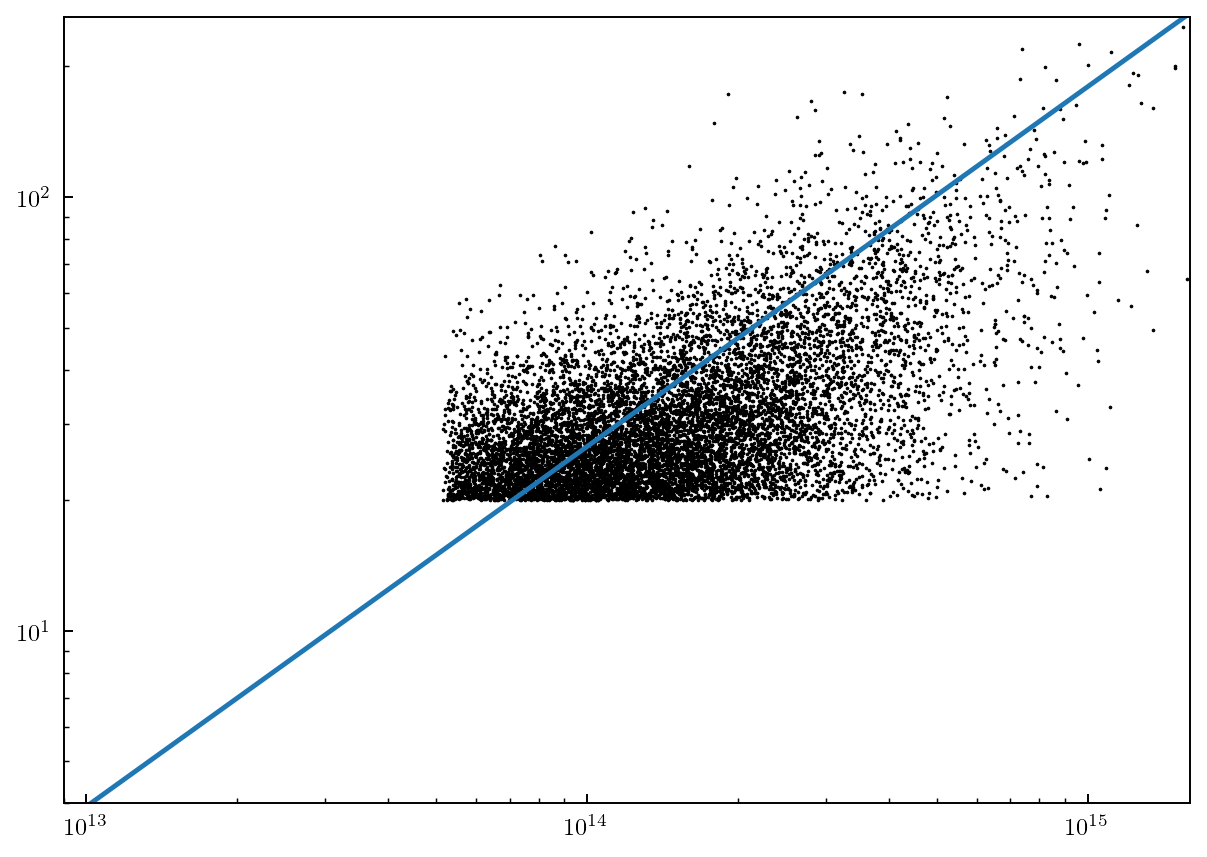

In [49]:
fig, axs = plt.subplots(1 ,1, tight_layout=True, figsize=(7,5))
#axs.plot(hrun_data_highz.M200B, hrun_data_highz.LAMBDA_CHISQ, 'k.', markersize=1)

axs.plot(hrun_data_highz.M200B, hrun_data_highz.LAMBDA_CHISQ, 'k.', markersize=1)
lnM_range = np.arange(25,38,0.1)

##For highz
lnA_post_maxL = lnA_post_model1_highz[1]; B_post_maxL = B_post_model1_highz[1]; sig0_post_maxL = sig0_post_model1_highz[1]
mu_lnl_model = lnA_post_maxL + B_post_maxL*(lnM_range-np.log(10)*14)
sig_lnl_model=np.sqrt(sig0_post_maxL**2+(np.exp(mu_lnl_model)-1)/(np.exp(2*mu_lnl_model)))

axs.plot(10**(lnM_range/np.log(10)), np.exp(mu_lnl_model), \
            label='Combined', linewidth=2)

axs.set_ylim((4,260))
axs.set_xlim((9e12,1.6e15))

plt.xscale('log'); plt.yscale('log')

plt.show()